In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from discretize import TensorMesh
from SimPEG import simulation, maps
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from SimPEG.electromagnetics.static import resistivity as dc, utils as dcutils
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.stats import norm
import scipy.sparse as sp
import copy
from scipy import stats

import multiprocessing
import time
from scipy.sparse import diags
from pymatsolver import Pardiso as Solver


In [135]:
# models = np.load('../rto_models_2d_l1px2py2pz2.npy')
# models = np.load('../rto_models_2d_l0px2py2pz2.npy')
# models = np.load('../rto_models_2d_l2px2py2pz2_200samples.npy')
# models = np.load('../rto_models_2d_l2px2py2pz2_5samples.npy')
# models = np.load('../rto_models_2d_l1px1py1pz1.npy')
# models2 = np.load('../rto_models_2d_l2.npy')
# models = np.load('../hmc_2d_L2p2.npy')

models = np.load('/home/johnathan/Documents/git/transformers_segmentation/bayesian_inversion/rto_iterations/rto_2d_shperes_l2p2_100samples.npy')

In [136]:
print(models.shape)
results = models

(100, 7021)


In [137]:
import discretize
import copy
# 2D Mesh
#########
csx,  csy,  csz = 0.25,  0.25,  0.25
# Number of core cells in each direction
ncx,  ncz = 123,  61
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

# 2-cylinders Model Creation
##########################
# Spheres parameters
x0,  z0,  r0 = -6.,  -5.,  3.
x1,  z1,  r1 = 6.,  -5.,  3.

ln_sigback = -np.log(500.)
ln_sigc = -np.log(90.)
ln_sigr = -np.log(50.)

# Add some variability to the physical property model
noisemean = 0.
noisevar = np.sqrt(0.001)
ln_over = -2.

mtrue = ln_sigback * np.ones(mesh.nC) + norm(noisemean, noisevar).rvs(mesh.nC)
# mprim = copy.deepcopy(mtrue)

csph = (np.sqrt((mesh.gridCC[:, 1] - z0) **
                2. + (mesh.gridCC[:, 0] - x0)**2.)) < r0
mtrue[csph] = ln_sigc * np.ones_like(mtrue[csph]) + \
    norm(noisemean, noisevar).rvs(np.prod((mtrue[csph]).shape))

# Define the sphere limit
rsph = (np.sqrt((mesh.gridCC[:, 1] - z1) **
                2. + (mesh.gridCC[:, 0] - x1)**2.)) < r1
mtrue[rsph] = ln_sigr * np.ones_like(mtrue[rsph]) + \
    norm(noisemean, noisevar).rvs(np.prod((mtrue[rsph]).shape))

# sphere smaller but higher conductivity
csph = (np.sqrt((mesh.gridCC[:, 1] - z0) **
                2. + (mesh.gridCC[:, 0] - x0)**2.)) < r0



# mtrue = utils.mkvc(mtrue)
xmin,  xmax = -15., 15
ymin,  ymax = -15., 0.
#xmin,  xmax = mesh.vectorNx.min(), mesh.vectorNx.max()
#ymin,  ymax = mesh.vectorNy.min(), mesh.vectorNy.max()
print(xmin,xmax,ymin,ymax)
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = discretize.utils.mesh_utils.extract_core_mesh(xyzlim, mesh)

-15.0 15 -15.0 0.0


/tmp/ipykernel_452811/1230406228.py:2: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(np.exp(np.vstack(results).mean(axis=0)), ax=ax[0], pcolorOpts={'cmap':"Spectral_r"})
/home/johnathan/anaconda3/envs/jenv/lib/python3.11/site-packages/discretize/utils/code_utils.py:313: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  return getattr(self, new_name)(*args, **kwargs)
/tmp/ipykernel_452811/1230406228.py:33: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat2 = meshCore.plotImage(std_plot_model, ax=ax[1], pcolorOpts={'cmap':"Spectral_r"})


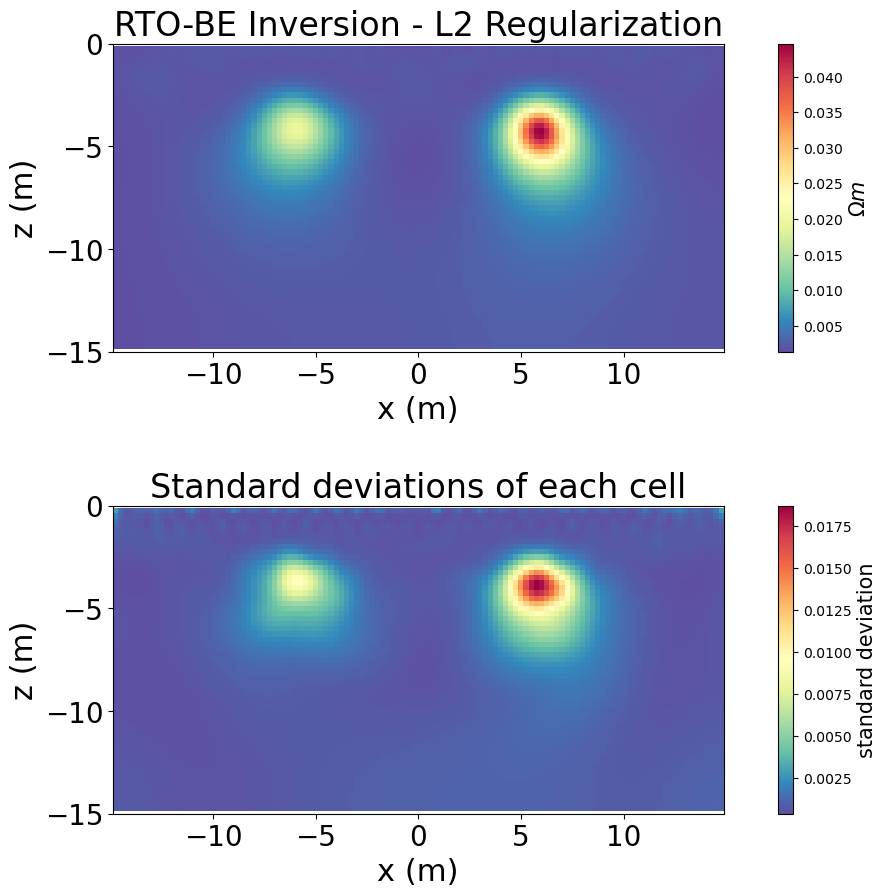

In [138]:


fig, ax = plt.subplots(2,1,figsize=(15,10))
dat = meshCore.plotImage(np.exp(np.vstack(results).mean(axis=0)), ax=ax[0], pcolorOpts={'cmap':"Spectral_r"})
# dat22 = meshCore.plotImage(np.exp(np.vstack(models2).mean(axis=0)), ax=ax[0], pcolorOpts={'cmap':"Spectral_r", 'alpha':0.1})
ax[0].set_title('RTO-BE Inversion - L2 Regularization',fontsize=24)
ax[0].set_aspect('equal')
ax[0].set_ylim([-15,0])
ax[0].set_xlabel('x (m)',fontsize=22)
ax[0].set_ylabel('z (m)',fontsize=22)
ax[0].tick_params(labelsize=20)
# fig.subplots_adjust(right=0.85)
plt.colorbar(dat[0]).set_label(label=r'$\Omega m$',size=15,weight='bold')


std_plot_model = np.exp(np.vstack(results).std(axis=0))
percentile_idx = std_plot_model < 0.006
std_plot_model[percentile_idx] = np.nan
# dat2 = meshCore.plotImage(std_plot_model, ax=ax[0], clim=[0, 0.05], pcolorOpts={'cmap':"binary", 'alpha':0.5})

# utils.plot2Ddata(

#     meshCore.gridCC,std_plot_model,nx=500,ny=500,
#     contourOpts={'alpha':0.1, 'cmap':"binary"},
#     #clim=[0,5],
#     ax=ax[0],
#     level=True,
#     ncontour=15,
#     levelOpts={'colors':'k','linewidths':1,'linestyles':'-', 'alpha':0.3},
#     method='nearest'
    
# )

std_plot_model = np.std(np.exp(np.vstack(results)), axis=0)
dat2 = meshCore.plotImage(std_plot_model, ax=ax[1], pcolorOpts={'cmap':"Spectral_r"})
# dat2 = meshCore.plotImage(np.std(np.exp(np.vstack(models2)), axis=0), ax=ax[1], pcolorOpts={'cmap':"Spectral_r", 'alpha':0.3})
ax[1].set_title('Standard deviations of each cell',fontsize=24)
ax[1].set_aspect('equal')
ax[1].set_ylim([-15,0])
ax[1].set_xlabel('x (m)',fontsize=22)
ax[1].set_ylabel('z (m)',fontsize=22)
ax[1].tick_params(labelsize=20)
plt.colorbar(dat2[0]).set_label(label=r'standard deviation',size=15)

fig.subplots_adjust(right=0.85, hspace=0.5)

plt.show()
# ------------------------------------------------------------------------------------------------

# # generate acquisition data (true data)

# #

# # Setup a Dipole-Dipole Survey with 1m and 2m dipoles
# xmin, xmax = -15., 15.
# ymin, ymax = 0., 0.
# zmin, zmax = 0, 0

# endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
# survey1 = dcutils.generate_dcip_survey(
#     endl, survey_type="dipole-dipole", dim=mesh.dim,
#     a=1, b=1, n=16, d2flag='2.5D'
# )
# survey2 = dcutils.generate_dcip_survey(
#     endl, survey_type="dipole-dipole", dim=mesh.dim,
#     a=2, b=2, n=16, d2flag='2.5D'
# )

# survey = dc.Survey(survey1.source_list + survey2.source_list)

# # Setup Problem with exponential mapping and Active cells only in the core mesh
# expmap = maps.ExpMap(mesh)
# mapactive = maps.InjectActiveCells(
#     mesh=mesh,  indActive=actcore,
#     valInactive=-np.log(1e8)
# )
# mapping = expmap * mapactive
# simulation = dc.Simulation2DNodal(
#     mesh,
#     survey,
#     sigmaMap=mapping,
#     storeJ=True,
#     solver=Solver
# )

# std_sim = 0.02

# simulation_data = simulation.make_synthetic_data(mtrue[actcore], relative_error=std_sim, force=True)
# # survey.eps = 1e-4
# simulation.survey.dobs = simulation_data.dobs

# std = 0.002 * np.abs(simulation.survey.dobs)

# Wd = np.diag(std)

# perturbed_data = np.random.multivariate_normal(simulation.survey.dobs, Wd, size=1)[0, :]
# data_object = data.Data(simulation.survey, dobs=perturbed_data, standard_deviation=std)

# dmis_rto = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

(100, 119, 59) (119, 59)


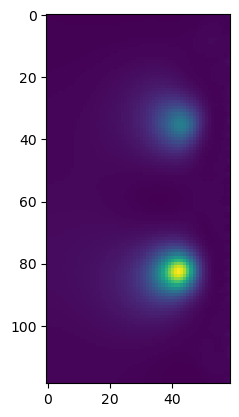

In [140]:
reshape_model = np.exp(results).mean(axis=0).reshape((meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')
reshaped_draws = np.exp(results).reshape((100, meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')
print(reshaped_draws.shape, reshape_model.shape)
reshape_model_std = np.exp(results).std(axis=0).reshape((meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')
# print(meshCore.cell_centers_y)

plt.imshow(reshape_model)
plt.show()

# plt.plot(meshCore.cell_centers_y, reshape_model[83, :], '.-')

/tmp/ipykernel_452811/3769310473.py:7: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(np.exp(np.vstack(results).mean(axis=0)), ax=ax[0, 0], pcolorOpts={'cmap':"Spectral_r"})
/home/johnathan/anaconda3/envs/jenv/lib/python3.11/site-packages/discretize/utils/code_utils.py:313: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  return getattr(self, new_name)(*args, **kwargs)


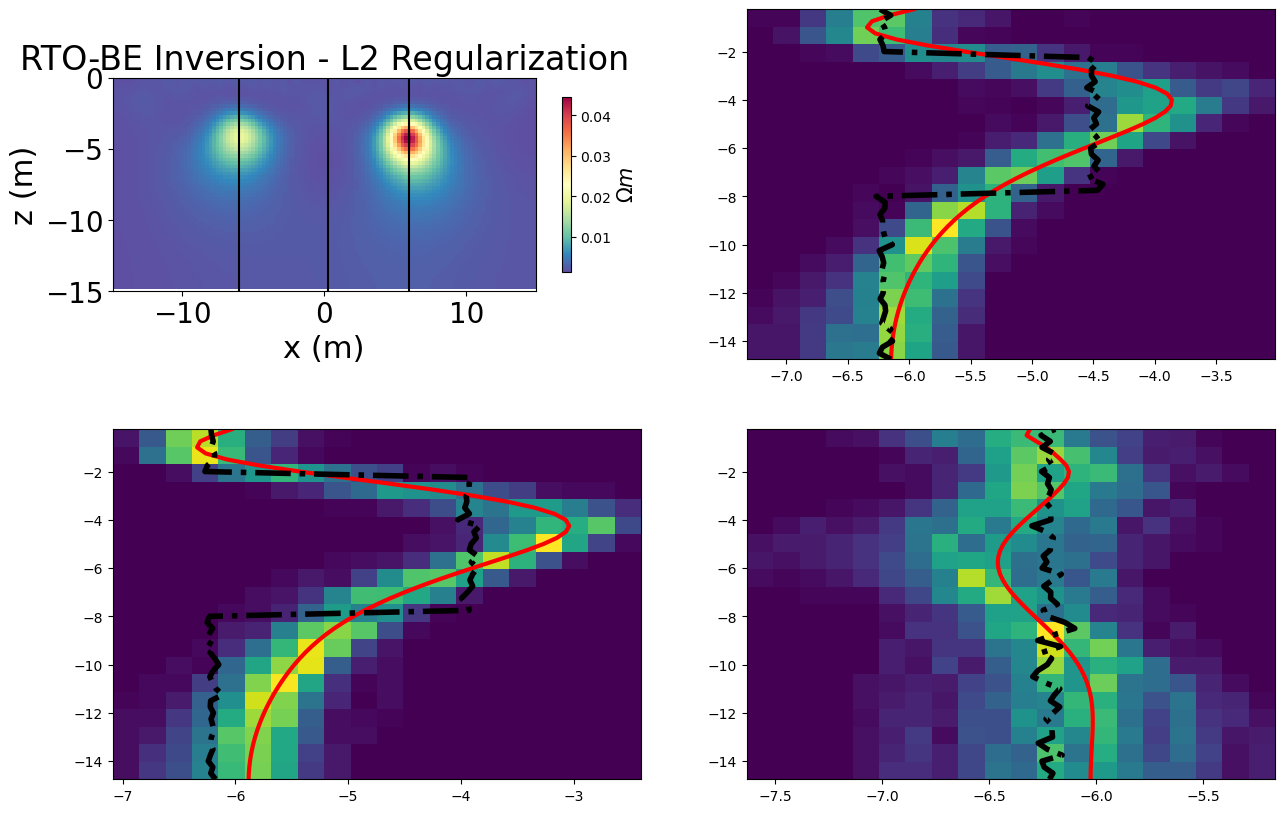

In [214]:
fig, ax = plt.subplots(ncols=2, nrows=2,figsize=(15,10))

x_line0 = 83
x_line = 60
x_line1 = 35

dat = meshCore.plotImage(np.exp(np.vstack(results).mean(axis=0)), ax=ax[0, 0], pcolorOpts={'cmap':"Spectral_r"})
# dat22 = meshCore.plotImage(np.exp(np.vstack(models2).mean(axis=0)), ax=ax[0], pcolorOpts={'cmap':"Spectral_r", 'alpha':0.1})
ax[0, 0].set_title('RTO-BE Inversion - L2 Regularization',fontsize=24)
ax[0, 0].set_aspect('equal')
ax[0, 0].set_ylim([-15,0])
ax[0, 0].set_xlabel('x (m)',fontsize=22)
ax[0, 0].set_ylabel('z (m)',fontsize=22)
ax[0, 0].tick_params(labelsize=20)
ax[0, 0].axvline(x = meshCore.cell_centers_x[x_line0], color = 'k', label = 'axvline - full height')
ax[0, 0].axvline(x = meshCore.cell_centers_x[x_line], color = 'k', label = 'axvline - full height')
ax[0, 0].axvline(x = meshCore.cell_centers_x[x_line1], color = 'k', label = 'axvline - full height')
# fig.subplots_adjust(right=0.85)
plt.colorbar(dat[0], shrink=0.5).set_label(label=r'$\Omega m$',size=15,weight='bold')
# print(np.array(reshaped_draws[:, 83, :]).reshape(-1).shape, np.tile(mesh.cell_centers_y, 5).shape, reshaped_draws[:, 83, :].mean(axis=0).shape, meshCore.cell_centers_y.shape)
ax[1, 0].hist2d(np.log(np.array(reshaped_draws[:, x_line0, :]).reshape(-1)), np.tile(meshCore.cell_centers_y, 100),bins=20, cmap='viridis')
ax[1, 0].plot(np.log(reshape_model[x_line0, :]), meshCore.cell_centers_y, '-r', linewidth=3.0)
mtrue_reshaped = mtrue[actcore].reshape((meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')
ax[1, 0].plot(mtrue_reshaped[x_line0, :], meshCore.cell_centers_y, '-.k', linewidth=4.0)


ax[1, 1].hist2d(np.log(np.array(reshaped_draws[:, x_line, :]).reshape(-1)), np.tile(meshCore.cell_centers_y, 100),bins=20, cmap='viridis')
ax[1, 1].plot(np.log(reshape_model[x_line, :]), meshCore.cell_centers_y, '-r', linewidth=3.0)
mtrue_reshaped = mtrue[actcore].reshape((meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')
ax[1, 1].plot(mtrue_reshaped[x_line, :], meshCore.cell_centers_y, '-.k', linewidth=4.0)

ax[0, 1].hist2d(np.log(np.array(reshaped_draws[:, x_line1, :]).reshape(-1)), np.tile(meshCore.cell_centers_y, 100),bins=20, cmap='viridis')
ax[0, 1].plot(np.log(reshape_model[x_line1, :]), meshCore.cell_centers_y, '-r', linewidth=3.0)
mtrue_reshaped = mtrue[actcore].reshape((meshCore.h[0].shape[0], meshCore.h[1].shape[0]), order='F')
ax[0, 1].plot(mtrue_reshaped[x_line1, :], meshCore.cell_centers_y, '-.k', linewidth=4.0)

/tmp/ipykernel_452811/154856656.py:8: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(np.exp(np.vstack(results).mean(axis=0)), ax=ax[0], pcolorOpts={'cmap':"Spectral_r"})
/tmp/ipykernel_452811/154856656.py:39: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat2 = meshCore.plotImage(std_plot_model, ax=ax[1], pcolorOpts={'cmap':"Spectral_r"})


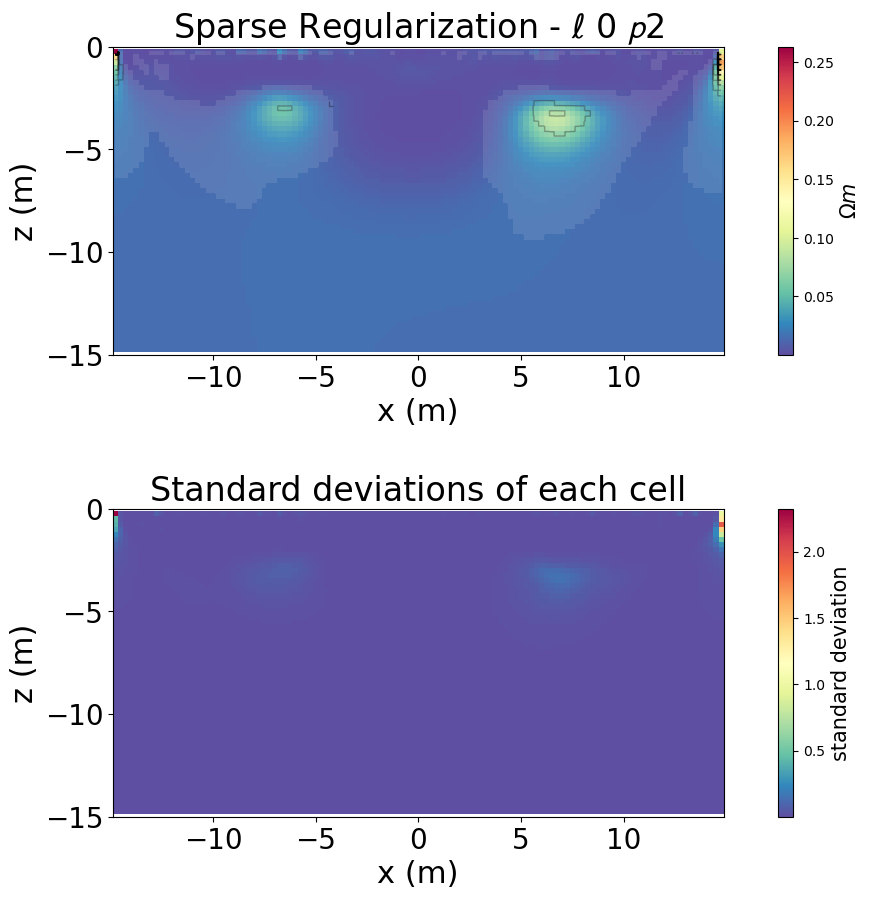

/home/johnathan/Documents/git/simpeg/SimPEG/electromagnetics/static/resistivity/simulation_2d.py:756: RuntimeWarning: invalid value encountered in divide
  r_hat = r_vec / r[:, None]
/home/johnathan/Documents/git/simpeg/SimPEG/electromagnetics/static/resistivity/simulation_2d.py:783: RuntimeWarning: invalid value encountered in divide
  alpha[not_top] = (ky * k1e(ky * r) / k0e(ky * r) * r_dot_n)[not_top]


In [64]:
results = np.load('../rto_models_2d_l0px2py2pz2.npy')
# results = np.load('../rto_models_2d_l2-sparse.npy')
# norm_title = r'Sparse Regularization - $\ell$ 1 $\mathcal{p}$2'
norm_title = r'Sparse Regularization - $\ell$ 0 $\mathcal{p}$2'
# norm_title = r'Sparse Regularization - $\ell$ 0 $\mathcal{p}$1'

fig, ax = plt.subplots(2,1,figsize=(15,10))
dat = meshCore.plotImage(np.exp(np.vstack(results).mean(axis=0)), ax=ax[0], pcolorOpts={'cmap':"Spectral_r"})
# dat22 = meshCore.plotImage(np.exp(np.vstack(models2).mean(axis=0)), ax=ax[0], pcolorOpts={'cmap':"Spectral_r", 'alpha':0.1})
ax[0].set_title(norm_title,fontsize=24)
ax[0].set_aspect('equal')
ax[0].set_ylim([-15,0])
ax[0].set_xlabel('x (m)',fontsize=22)
ax[0].set_ylabel('z (m)',fontsize=22)
ax[0].tick_params(labelsize=20)
# fig.subplots_adjust(right=0.85)
plt.colorbar(dat[0]).set_label(label=r'$\Omega m$',size=15,weight='bold')


std_plot_model = np.std(np.exp(np.vstack(results)), axis=0)
percentile_idx = std_plot_model < 0.006
std_plot_model[percentile_idx] = np.nan
# dat2 = meshCore.plotImage(std_plot_model, ax=ax[0], clim=[0, 0.05], pcolorOpts={'cmap':"binary", 'alpha':0.5})

utils.plot2Ddata(

    meshCore.gridCC,std_plot_model,nx=500,ny=500,
    contourOpts={'alpha':0.1, 'cmap':"binary"},
    #clim=[0,5],
    ax=ax[0],
    level=True,
    ncontour=35,
    levelOpts={'colors':'k','linewidths':1,'linestyles':'-', 'alpha':0.3},
    method='nearest'
    
)

std_plot_model = np.std(np.exp(np.vstack(results)), axis=0)
dat2 = meshCore.plotImage(std_plot_model, ax=ax[1], pcolorOpts={'cmap':"Spectral_r"})
# dat2 = meshCore.plotImage(np.std(np.exp(np.vstack(models2)), axis=0), ax=ax[1], pcolorOpts={'cmap':"Spectral_r", 'alpha':0.3})
ax[1].set_title('Standard deviations of each cell',fontsize=24)
ax[1].set_aspect('equal')
ax[1].set_ylim([-15,0])
ax[1].set_xlabel('x (m)',fontsize=22)
ax[1].set_ylabel('z (m)',fontsize=22)
ax[1].tick_params(labelsize=20)
plt.colorbar(dat2[0]).set_label(label=r'standard deviation',size=15)

fig.subplots_adjust(right=0.85, hspace=0.5)

plt.show()
# ------------------------------------------------------------------------------------------------

# generate acquisition data (true data)

#

# Setup a Dipole-Dipole Survey with 1m and 2m dipoles
xmin, xmax = -15., 15.
ymin, ymax = 0., 0.
zmin, zmax = 0, 0

endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
survey1 = dcutils.generate_dcip_survey(
    endl, survey_type="dipole-dipole", dim=mesh.dim,
    a=1, b=1, n=16, d2flag='2.5D'
)
survey2 = dcutils.generate_dcip_survey(
    endl, survey_type="dipole-dipole", dim=mesh.dim,
    a=2, b=2, n=16, d2flag='2.5D'
)

survey = dc.Survey(survey1.source_list + survey2.source_list)

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = maps.ExpMap(mesh)
mapactive = maps.InjectActiveCells(
    mesh=mesh,  indActive=actcore,
    valInactive=-np.log(1e8)
)
mapping = expmap * mapactive
simulation = dc.Simulation2DNodal(
    mesh,
    survey,
    sigmaMap=mapping,
    storeJ=True,
    solver=Solver
)

std_sim = 0.02

simulation_data = simulation.make_synthetic_data(mtrue[actcore], relative_error=std_sim, force=True)
# survey.eps = 1e-4
simulation.survey.dobs = simulation_data.dobs

std = 0.002 * np.abs(simulation.survey.dobs)

Wd = np.diag(std)

perturbed_data = np.random.multivariate_normal(simulation.survey.dobs, Wd, size=1)[0, :]
data_object = data.Data(simulation.survey, dobs=perturbed_data, standard_deviation=std)

dmis_rto = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

Text(0.5, 1.0, 'norm: 105.20732147861293')

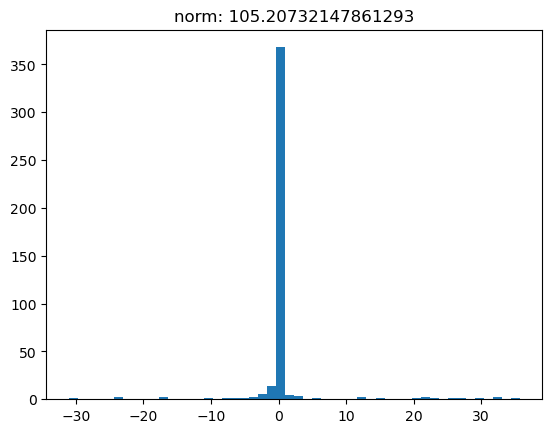

In [7]:
dmis1_rto = data_misfit.L1DataMisfit(simulation=simulation, data=data_object)
r = dmis1_rto.residual(np.vstack(results).mean(axis=0))
plt.hist(r, 50)
plt.title(f'norm: {np.linalg.norm(r)}')


In [14]:
# weighted_diff = dmis1_rto.W.diagonal() * r

# mask = weighted_diff <=  1.0

# print(mask.shape)
dmis1_rto.deriv(np.vstack(results).mean(axis=0))

KeyboardInterrupt: 

In [38]:
import numpy as np

class L1HuberLossObjective:
    def __init__(self, W, F):
        self.W = np.diag(W)  # Convert weights to a diagonal matrix
        self.F = F
    
    def evaluate(self, m, D):
        predicted = self.F(m)
        diff = predicted - D
        weighted_diff = np.dot(self.W, diff)
        
        delta = 1.0
        abs_diff = np.abs(weighted_diff)
        mask = abs_diff <= delta
        
        # Huber loss computation
        loss = np.sum(np.where(mask, 0.5 * abs_diff ** 2, delta * (abs_diff - 0.5 * delta)))
        
        return loss
    
    def gradient(self, m, D, epsilon=1e-6):
        grad = np.zeros_like(m)
        for i in range(len(m)):
            m_plus_eps = m.copy()
            m_plus_eps[i] += epsilon
            loss_plus_eps = self.evaluate(m_plus_eps, D)
            
            m_minus_eps = m.copy()
            m_minus_eps[i] -= epsilon
            loss_minus_eps = self.evaluate(m_minus_eps, D)
            
            grad[i] = (loss_plus_eps - loss_minus_eps) / (2 * epsilon)
        
        return grad
    
    def second_derivative(self, m, D, epsilon=1e-6):
        hess = np.zeros((len(m), len(m)))
        for i in range(len(m)):
            for j in range(len(m)):
                m_plus_plus = m.copy()
                m_plus_plus[i] += epsilon
                m_plus_plus[j] += epsilon
                loss_plus_plus = self.evaluate(m_plus_plus, D)
                
                m_plus_minus = m.copy()
                m_plus_minus[i] += epsilon
                m_plus_minus[j] -= epsilon
                loss_plus_minus = self.evaluate(m_plus_minus, D)
                
                m_minus_plus = m.copy()
                m_minus_plus[i] -= epsilon
                m_minus_plus[j] += epsilon
                loss_minus_plus = self.evaluate(m_minus_plus, D)
                
                m_minus_minus = m.copy()
                m_minus_minus[i] -= epsilon
                m_minus_minus[j] -= epsilon
                loss_minus_minus = self.evaluate(m_minus_minus, D)
                
                hess[i][j] = (loss_plus_plus - loss_plus_minus - loss_minus_plus + loss_minus_minus) / (4 * epsilon ** 2)
        
        return hess

# Example usage:
# Define function F (you'd need to define this function)
def F(m):
    # Example function, you should replace this with your own
    return np.dot(m, np.array([2, 3, 4]))  # Example predicted data calculation

# Define weights W as a vector
weights = [2, 3, 4]  # Example weights

# Define observed data D as a vector
observed_data = np.array([5, 7, 9])  # Example observed data

# Create an instance of the L1HuberLossObjective class
l1_huber_obj = L1HuberLossObjective(W=weights, F=F)

# Evaluate the loss at a specific value of m and observed data D
m_value = np.array([1.5, 2.0, 3.0])  # Example m value
loss_result = l1_huber_obj.evaluate(m_value, observed_data)
print("Loss at m =", m_value, ":", loss_result)

# Calculate the gradient at a specific value of m and observed data D
gradient_result = l1_huber_obj.gradient(m_value, observed_data)
print("Gradient at m =", m_value, ":", gradient_result)

# Calculate the second derivatives at a specific value of m and observed data D
second_derivative_result = l1_huber_obj.second_derivative(m_value, observed_data)
print("Hessian at m =", m_value, ":", second_derivative_result)


Loss at m = [1.5 2.  3. ] : 120.5
Gradient at m = [1.5 2.  3. ] : [18.00000001 26.99999999 36.00000001]
Hessian at m = [1.5 2.  3. ] : [[ 0.         -0.01065814  0.        ]
 [-0.01065814  0.          0.        ]
 [ 0.          0.          0.        ]]


# Dipping rto-be

In [170]:
rto_dip = np.load('../rto_models_2d_dip_test_l2p2.npy')


  TensorMesh: 13,651 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    187     -2,338.70      2,338.70      5.00    648.73    1.50
   y     73     -2,233.70          2.50      5.00    648.73    1.50




/tmp/ipykernel_146906/2974248904.py:42: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  mm1 = mesh.plotImage(model, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})
/tmp/ipykernel_146906/2974248904.py:61: FutureWarning: ExtractCoreMesh has been deprecated, please use extract_core_mesh. It will be removed in version 0.19.0 of SimPEG.
  actcore,  meshCore = utils.mesh_utils.ExtractCoreMesh(xyzlim, mesh)
/tmp/ipykernel_146906/2974248904.py:66: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(1 / np.exp(np.vstack(results).mean(axis=0)),clim=[0, 500], ax=ax[1], pcolorOpts={'cmap':"Spectral"})
/tmp/ipykernel_146906/2974248904.py:79: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat2 = mes

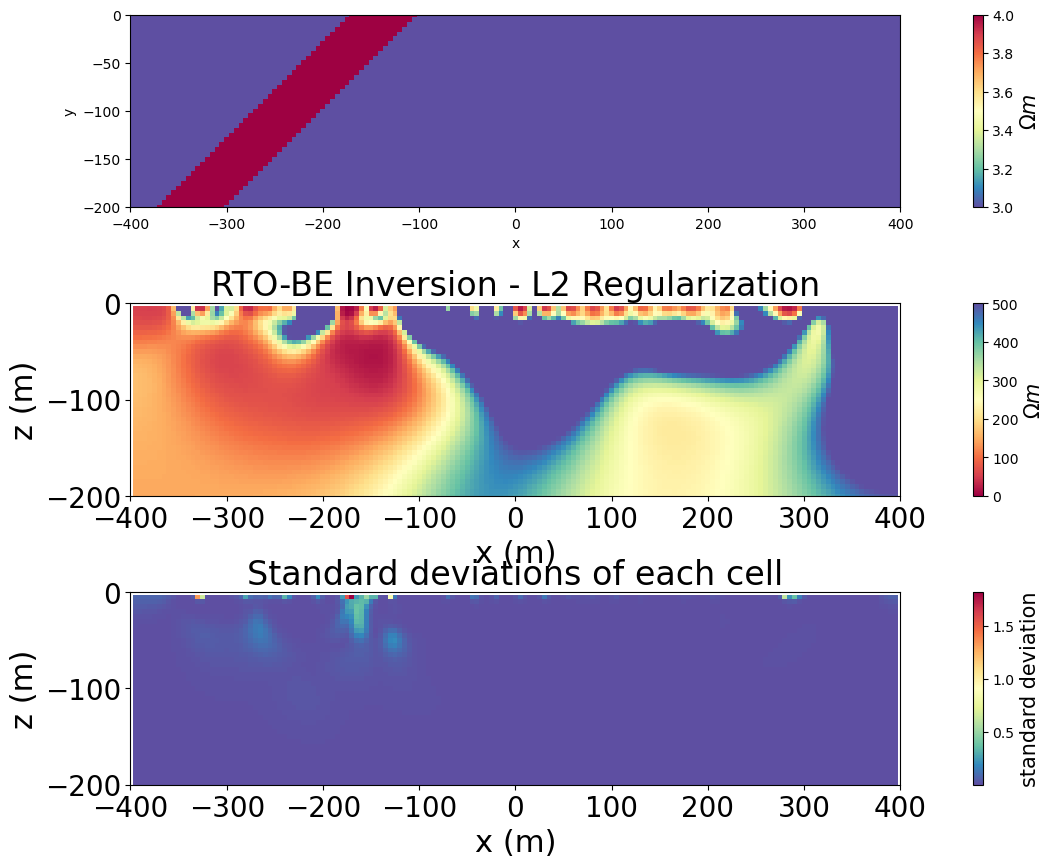

In [171]:
# -------------------------------------------------------------------------------------------------

# create a 2d mesh for a dc simulation

#

#2D mesh
csx,  csy,  csz = 5.,  5.,  5.
# Number of core cells in each direction
ncx,  ncz = 163,  61
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

print(mesh)

# -----------------------------------------------------------------------

# create a synthetic model for a dc simulation

#

model = 3 * np.ones(mesh.nC, dtype='int64')

# divide domain by  45* fault at 100 m
fault_function = lambda x, slope, shift: slope * x + shift

# Dike 45*
dike0 = mesh.gridCC[:,1] > fault_function(mesh.gridCC[:,0],1, 100)
dike1 = mesh.gridCC[:,1] < fault_function(mesh.gridCC[:,0],1, 175)
dike = np.logical_and(dike0,dike1)

model[dike]=4

# plot
fig,ax = plt.subplots(3, 1,figsize=(20,10))
mm1 = mesh.plotImage(model, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})
ax[0].set_xlim([-400, 400])
ax[0].set_ylim([-200, 0])
ax[0].set_aspect('equal')
plt.colorbar(mm1[0]).set_label(label=r'$\Omega m$',size=15,weight='bold')

# define conductivities
res_true = np.ones(mesh.nC)
res_true[model==3]= 500.0
res_true[model==4]= 10.0

cond_true = 1./res_true

mtrue = np.log(cond_true)

xmin, xmax = -400., 400.
ymin, ymax = -300., 0.
zmin, zmax = 0, 0
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = utils.mesh_utils.ExtractCoreMesh(xyzlim, mesh)
actind = np.ones_like(actcore)

# fig, ax = plt.subplots(2,1,figsize=(15,10))
results = rto_dip
dat = meshCore.plotImage(1 / np.exp(np.vstack(results).mean(axis=0)),clim=[0, 500], ax=ax[1], pcolorOpts={'cmap':"Spectral"})
# dat22 = meshCore.plotImage(np.exp(np.vstack(models2).mean(axis=0)), ax=ax[0], pcolorOpts={'cmap':"Spectral_r", 'alpha':0.1})
ax[1].set_title('RTO-BE Inversion - L2 Regularization',fontsize=24)
ax[1].set_xlim([-400, 400])
ax[1].set_ylim([-200, 0])
ax[1].set_xlabel('x (m)',fontsize=22)
ax[1].set_ylabel('z (m)',fontsize=22)
ax[1].tick_params(labelsize=20)
ax[1].set_aspect('equal')
# fig.subplots_adjust(right=0.85)
plt.colorbar(dat[0]).set_label(label=r'$\Omega m$',size=15,weight='bold')

std_plot_model = np.std(np.exp(np.vstack(results)), axis=0)
dat2 = meshCore.plotImage(std_plot_model, ax=ax[2], pcolorOpts={'cmap':"Spectral_r"})
# dat2 = meshCore.plotImage(np.std(np.exp(np.vstack(models2)), axis=0), ax=ax[1], pcolorOpts={'cmap':"Spectral_r", 'alpha':0.3})
ax[2].set_title('Standard deviations of each cell',fontsize=24)
ax[2].set_xlim([-400, 400])
ax[2].set_ylim([-200, 0])
ax[2].set_xlabel('x (m)',fontsize=22)
ax[2].set_ylabel('z (m)',fontsize=22)
ax[2].tick_params(labelsize=20)
ax[2].set_aspect('equal')
plt.colorbar(dat2[0]).set_label(label=r'standard deviation',size=15)

fig.subplots_adjust(right=0.85, hspace=0.5)
